# Custom Plots

You may will sometimes find yourself in a scenario where the standard plots are not a good fit for what you're doing.  Fortunately, data visualizations are usually combinations of rectangles, circles, lines, and text; learning how to draw those at specific coordinates is very powerful.  In this reading, we'll just focus on text.  The challenge will be the coordinates, as there are multiple simultaneous systems in any figure.

As a concrete example, we'll try to reconstruct a very elegant custom plot posted to the /r/dataisbeautiful subreddit:

https://www.reddit.com/r/dataisbeautiful/comments/lot486/frequency_of_letters_in_english_words_and_where/

The original plot looks like this:

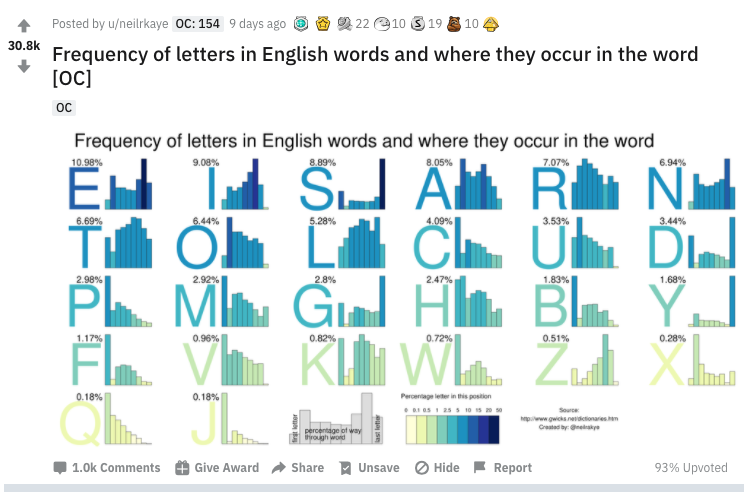

In [1]:
from IPython.core.display import Image
Image("reddit.png")

The order of the subplots tells you which letters are most common in English words ("E" is most common, representing 10.98% of occurences).  The bars in each subplot tell you where those letters occur within the word.  Y is almost aways at the end of a word; J is almost always at the beginning.

The version we'll create by the end of the reading will look like this:

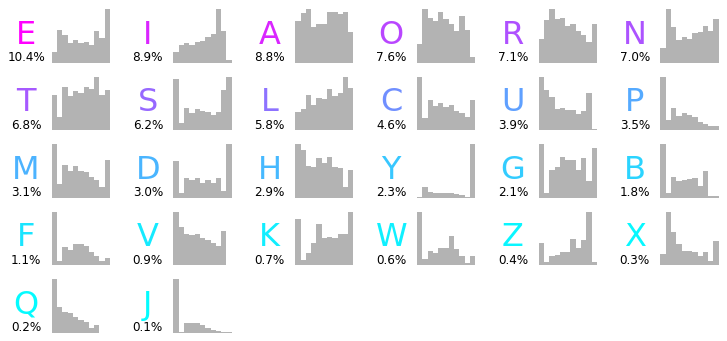

In [2]:
Image("reading.png")

## Constructing the Dataset

Before we try plotting, we want to build a table where there is one row per letter.  Each of ten colunns will represent a location within a word.  For example, 0.5 of the A row will tell us how many times the letter A appears in the middle of a word.

We'll can pull the capital letters from the alphabet using Python's builtin `string` module:

In [3]:
from string import ascii_letters
print(ascii_letters)
caps = list(ascii_letters[26:])
caps[:10]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

Let's start with an empty table with the desired rows and columns:

In [4]:
import pandas as pd
df = pd.DataFrame(0, index=caps, columns=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
df.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
A,0,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0


On Linux, the "/usr/share/dict/words" file usually contains a list of English words.  We can use the `head` command to see the first few lines.  Putting `!` in front of a command in Jupyter means to run this as a shell command (not Python code).

In [5]:
!head /usr/share/dict/words

A
a
aa
aal
aalii
aam
Aani
aardvark
aardwolf
Aaron


If a letter is at index `i` within a string `word`, then this will give us the position of that letter in the range 0 (beginning) to 1 (end), rounded to the nearest tenth: `round(i / (len(word) - 1), ndigits=1)`.  Let's test that with a simple example.

In [6]:
word = "ABC"
i = 0 # at what percent through the word does A occur?
print(round(i / (len(word) - 1), ndigits=1))
i = 1 # at what percent through the word does B occur?
print(round(i / (len(word) - 1), ndigits=1))
i = 2 # at what percent through the word does C occur?
print(round(i / (len(word) - 1), ndigits=1))

0.0
0.5
1.0


Ok, let's now loop over every letter of every word in the English dictionary, counting it in our big table as we go (`df.at[letter, position] += 1`).

In [7]:
with open("/usr/share/dict/words") as f:
    for word in list(f):
        word = word.strip().upper()
        if len(word) == 1:
            continue
        for i in range(len(word)):
            letter = word[i]
            position = round(i / (len(word) - 1) * 10) / 10
            if not letter in caps:
                continue
            df.at[letter, position] += 1

In [8]:
df.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
A,17111,20306,21680,14746,15727,15907,20566,20573,19775,20545,12616
B,11068,1080,4285,3411,3812,3854,4102,2401,5502,441,475
C,19905,4555,11380,8937,10067,8836,9381,7208,6651,5192,11326
D,10894,1501,6100,5240,5897,4598,5316,4610,5994,2052,15987
E,8748,27212,23450,16643,19035,16813,17079,14914,26509,20730,44196


Let's sum horizontally along each row, to determine the total number of occurences of each letter.  We can divide this by the total count and sort to rank the letters by frequency.

In [9]:
counts = df.sum(axis=1)
percents = counts / counts.sum() * 100
percents = percents.sort_values(ascending=False)
percents.head()

E    10.425848
I     8.906289
A     8.840809
O     7.562128
R     7.132076
dtype: float64

## Text Annotations: Coordinates and Colors

Eventually, we'll create a matrix like the following, using the first 26 subplots for the 26 letters:

In [10]:
%matplotlib inline

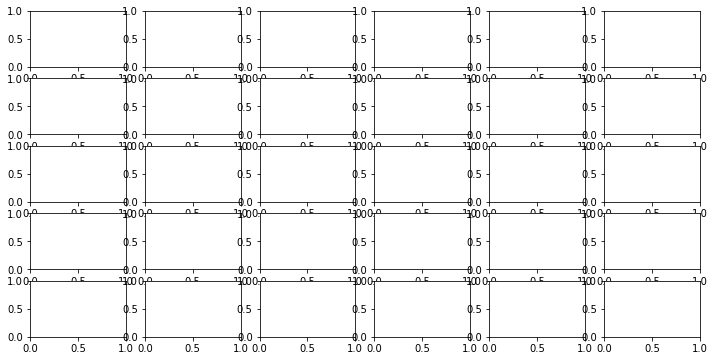

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(12, 6))

For now, let's think about how to plot one letter in one AxesSubplot.

In [12]:
df.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
A,17111,20306,21680,14746,15727,15907,20566,20573,19775,20545,12616
B,11068,1080,4285,3411,3812,3854,4102,2401,5502,441,475
C,19905,4555,11380,8937,10067,8836,9381,7208,6651,5192,11326
D,10894,1501,6100,5240,5897,4598,5316,4610,5994,2052,15987
E,8748,27212,23450,16643,19035,16813,17079,14914,26509,20730,44196


`df.loc[SOME_LETTER]` pulls out a row of the big table (corresponding to the given letter) as a Series, which is easy enough to plot in a given ax.

In [13]:
A = df.loc["A"]
A

0.0    17111
0.1    20306
0.2    21680
0.3    14746
0.4    15727
0.5    15907
0.6    20566
0.7    20573
0.8    19775
0.9    20545
1.0    12616
Name: A, dtype: int64

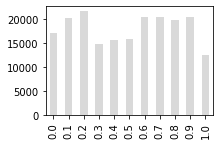

In [14]:
fig, ax = plt.subplots(figsize=(3,2))
A.plot.bar(ax=ax, color="0.85") # 0.5 is light gray (0 is black, 1 is white)

If we like, we can add some text using `ax.plot(x, y, text)`.

Text(3, 16000, 'hi')

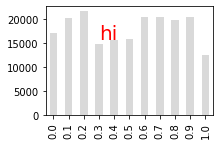

In [15]:
fig, ax = plt.subplots(figsize=(3,2))
A.plot.bar(ax=ax, color="0.85")
ax.text(3, 16000, "hi", transform=ax.transData, size=20, color="red")

The `transform=ax.transData` (which would have been the default had we exclude it) is telling matplotlib to interpret 3 and 16000 in terms of the scale of the data.  16000 makes sense by looking at the y-axis, but why is it 3 instead of 0.3?  Matplotlib is treating the x-axis like a category, even though it looks numeric, as we can see by looking at xlim:

In [16]:
ax.get_xlim()

(-0.5, 10.5)

`ax.transAxes` is a different coordinate system.  The bottom left of the subplot is x=0, y=0; the top right is x=1, y=1.  This is convenient, say, if we want to center the text (note that we're centering the bottom left of the text).

Text(0.5, 0.5, 'hi')

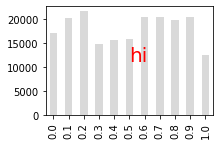

In [17]:
fig, ax = plt.subplots(figsize=(3,2))
A.plot.bar(ax=ax, color="0.85")
ax.text(0.5, 0.5, "hi", transform=ax.transAxes, size=20, color="red")

We can specify a negative x coord in the `ax.transAxes` coordinate system to make the text float to the left of the subplot.  Notice now that we're specifying the coordinates for the center (rather than the bottom left) by specifying alignment.

Text(-0.4, 0.5, 'A')

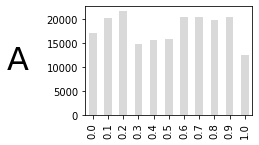

In [18]:
fig, ax = plt.subplots(figsize=(3,2))
A.plot.bar(ax=ax, color="0.85")
ax.text(-0.4, 0.5, "A", size=32,
        verticalalignment="center", horizontalalignment="center",
        transform=ax.transAxes)

Matplotlib has many colormaps that allow us to convert a quantity to point on a color bar: https://matplotlib.org/stable/gallery/color/colormap_reference.html.  Colors are represented as tuples.

In [19]:
print(plt.cm.cool(0))
print(plt.cm.cool(0.5))
print(plt.cm.cool(1))

(0.0, 1.0, 1.0, 1.0)
(0.5019607843137255, 0.4980392156862745, 1.0, 1.0)
(0.00392156862745098, 0.996078431372549, 1.0, 1.0)


We can use these colors for our text.

Text(-0.4, 0.7, 'C')

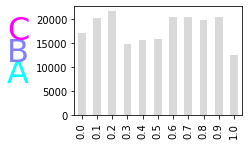

In [20]:
fig, ax = plt.subplots(figsize=(3,2))
A.plot.bar(ax=ax, color="0.85")
ax.text(-0.4, 0.3, "A", size=32, transform=ax.transAxes, color=plt.cm.cool(0))
ax.text(-0.4, 0.5, "B", size=32, transform=ax.transAxes, color=plt.cm.cool(0.5))
ax.text(-0.4, 0.7, "C", size=32, transform=ax.transAxes, color=plt.cm.cool(1.0))

We can use these colors to indicate something about the data (like letter frequency).

## Letter Frequencies: Putting it All Together

We've seen how we can pull the info for a given letter necessary to create a bar plot showing the frequency of different locations.  We've also seen how we can use the `ax.text` and the `ax.transAxes` coordinate system to add some text to the left of a subplot.  We're going to need to create 26 such subplots, so lets put together all that we've done so far into a `plot_letter` function.  We pass in `letter`, and the function directly grabs the relevant data from our `df` earlier in the notebook.  We also pass in `ax` so that the function knows where to plot.

In [21]:
def plot_letter(letter, ax):
    percent = percents.at[letter]
    color = plt.cm.cool(percent / percents.max())
    positions = df.loc[letter]
    positions = positions / positions.sum() * 100
    positions = positions[:10]
    ax.text(-0.4, 0.5, letter, size=32,
            verticalalignment="center", horizontalalignment="center",
            transform=ax.transAxes, color=color)
    ax.text(-0.4, 0.1, str(round(percent, 1)) + "%", size=12,
            horizontalalignment="center", verticalalignment="center",
            transform=ax.transAxes)
    positions.plot.bar(ax=ax, width=1, color="0.7")

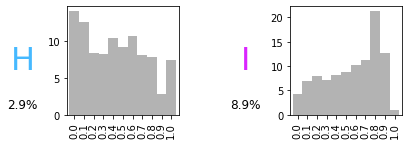

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 2))
plt.subplots_adjust(wspace=1)
plot_letter("H", axes[0])
plot_letter("I", axes[1])

We see we can use our `plot_letter` function to plots "H" and "I" in two subplots.  Let's try the whole alphabet.  Also, we can now get rid of the axes/borders using `ax.axis("off")` for a cleaner plot.

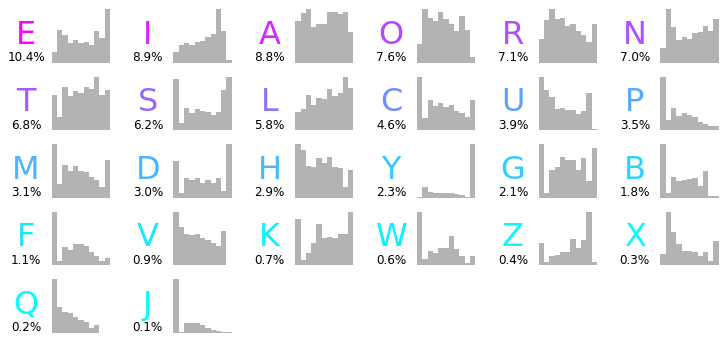

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(12, 6))
plt.subplots_adjust(wspace=1)
axes = list(axes.reshape(-1))

for i in range(len(percents)):
    letter = percents.index[i]
    plot_letter(letter, axes[i])

for ax in axes:
    ax.axis("off")

Finally, let's save our work.

In [24]:
fig.savefig("reading.png", bbox_inches="tight")